In [1]:
# import os
import sys
import gc

# прописываем нужный нам путь к проекту
from pathlib import Path
PATH = Path('../..') # proj_news_viz/nlp
sys.path.append(str(PATH))

import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# import matplotlib.pyplot as plt
# plt.style.use('dark_background')
%matplotlib inline

---
возьмем для примера датасет [News dataset from Lenta.Ru](https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta), скаченный по линку с [github](https://github.com/yutkin/Lenta.Ru-News-Dataset/tree/v1.1)

или выполнить следующие две команды в нужной Вам директории:

`$ wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2`

`$ bzip2 -d lenta-ru-news.csv.bz2`

In [3]:
df = pd.read_csv(PATH / 'data/external/lenta-ru-news.csv')
print(df.shape)
df.sample(2)

(800975, 6)


,url,title,text,topic,tags,date
281979,https://lenta.ru/news/2009/05/11/advisor/,Microsoft протестирует компьютеры на совместим...,Корпорация Microsoft выпустила бета-версию бес...,Интернет и СМИ,Все,2009/05/11
354160,https://lenta.ru/news/2010/11/25/antialfa/,"""Анти-Facebook"" запустил тестовую версию","Социальная сеть Diaspora, получившая известнос...",Интернет и СМИ,Все,2010/11/25


In [5]:
# удалим пустые записи и дубликаты по признаку `text`

df.dropna(inplace=True)
df.text.drop_duplicates(inplace=True)

print(f'df.shape: {df.shape}')
df.isnull().sum()

df.shape: (712654, 6)


url      0
title    0
text     0
topic    0
tags     0
date     0
dtype: int64

In [6]:
# посмотрим какие самые старые и новые статьи мы имеем
df.date.min(),df.date.max()

('1914/09/16', '2018/12/15')

In [7]:
# посмотрим на к-ство записей по разделам
print(f'уникальное к-ство разделов: {df.topic.unique().shape[0]}')
df.topic.value_counts()

уникальное к-ство разделов: 23


Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

In [8]:
# выберем для примера топ-5 разделов
top_topics = 5
df_top = df[df.topic.isin(df.topic.value_counts().head(top_topics).index)]
df_top.shape

(479471, 6)

In [9]:
df_top.date.min(), df_top.date.max()

('1999/08/31', '2018/12/15')

---
разделим данные для начала на train & test в соотношении 80/20 соответственно  со стратификацией по топиках

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_top.text,df_top.topic,
                                                    test_size=0.2,
                                                    stratify=df_top.topic,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((383576,), (95895,), (383576,), (95895,))

In [12]:
# проверим на пустые значения
X_train.isna().sum(), X_test.isna().sum()

(0, 0)

---
## сделаем небольшое исследование, обучив модель с и без препроцессинга

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
# добавим самописный файл, для отображения топ частотный слов
from news_viz.visualization.plot_frequency import plotFrequencyWords

* ### без препроцессинга

In [15]:
%%time

tfidf_vect = TfidfVectorizer()

# в данном примере обучим только на `X_train`
# но ничего не мешает обучить и на `X_test`
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_test = tfidf_vect.transform(X_test)

CPU times: user 1min 5s, sys: 802 ms, total: 1min 6s
Wall time: 1min 6s


In [16]:
# распределение токенов
vocab = {a: b for a, b in zip(tfidf_vect.get_feature_names(), np.ravel(tfidf_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер корпуса: {len(vocab)}')
print(f'\nпример [:5]: {vocab[:5]}')

размер корпуса: 734629

пример [:5]: [('на', 15871.815508813179), ('по', 10774.821058601865), ('что', 10639.430590100452), ('не', 8267.292710162437), ('из', 6925.430609163202)]


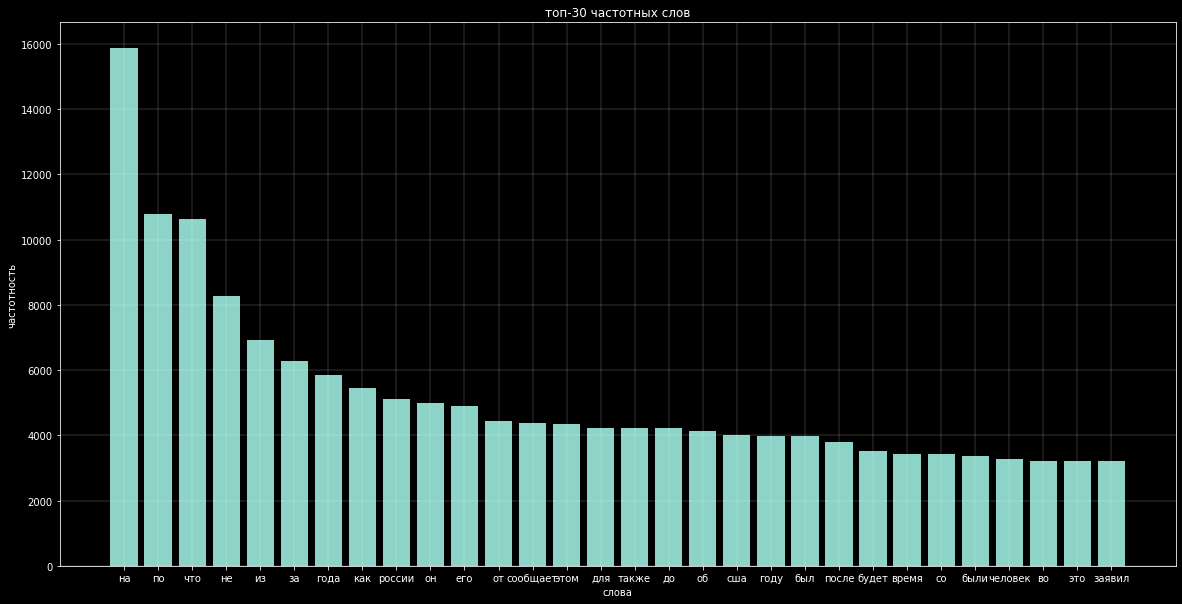

In [17]:
plotFrequencyWords(vocab = vocab,
                   top_words = 30,
                   plt_background = 'dark')

In [19]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(tfidf_vect_train, y_train)

pred_lr = lr.predict(tfidf_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.92715   0.96170   0.94411     10706
         Мир    0.89456   0.91070   0.90256     27324
      Россия    0.91902   0.87749   0.89777     31001
       Спорт    0.97936   0.97953   0.97945     11579
   Экономика    0.90995   0.94014   0.92480     15285

    accuracy                        0.91866     95895
   macro avg    0.92601   0.93391   0.92974     95895
weighted avg    0.91880   0.91866   0.91848     95895

confusion_matrix:
[[10296   160   206    13    31]
 [  360 24884  1581    62   437]
 [  360  2373 27203   131   934]
 [   31    86   100 11342    20]
 [   58   314   510    33 14370]]
CPU times: user 6min 26s, sys: 9min 3s, total: 15min 30s
Wall time: 3min 28s


In [ ]:
# from sklearn.pipeline import Pipeline
# 
# pipe = Pipeline([('vec', TfidfVectorizer()),
#                 ('clf', LogisticRegression(class_weight='balanced', random_state=42))])
# 
# pipe.fit(X_train,y_train)
# 
# pred_lr = pipe.predict(X_test)
# print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
# print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

* ### c препроцессингом

In [21]:
# импортируем кастомный наш препроцессинг
from news_viz.data.preprocessing_tools import clean_text, lemmatize
# pip install pymorphy2

In [22]:
# импортируем нужные нам библиотеки для мультипроцессинга
# создаем соответствующую для этого функцию
import multiprocessing as mp
from multiprocessing import Pool

num_cores = mp.cpu_count() # number of cores on your machine; 20
num_partitions = num_cores * 2 # number of partitions to split dataframe

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [23]:
train = pd.DataFrame(X_train)
train['target'] = pd.DataFrame(y_train)

test = pd.DataFrame(X_test)
test['target'] = pd.DataFrame(y_test)

* оставим только слова

In [24]:
def multiply_clean_text(data):
    data['clean_text'] = data['text'].apply(clean_text)
    return data

In [25]:
%%time

print('clean train text & drop missing rows ...')
train = parallelize_dataframe(train, multiply_clean_text)
train = train[train.clean_text != 'TOREMOVE']

print('clean test text & drop missing rows ...')
test = parallelize_dataframe(test, multiply_clean_text)
test = test[test.clean_text != 'TOREMOVE']

gc.collect()

clean train text & drop missing rows ...
clean test text & drop missing rows ...
CPU times: user 8.94 s, sys: 7.92 s, total: 16.9 s
Wall time: 18.3 s


0

* лемматизируем и удалим заодно стоп-слова

In [26]:
def multiply_lemmatization(data):
    data['lemma_text'] = data['clean_text'].apply(lemmatize)
    return data

In [27]:
%%time

print('lemmatization train ...')
train = parallelize_dataframe(train, multiply_lemmatization)
train = train[train.lemma_text != 'TOREMOVE']

gc.collect()

print('lemmatization test ...')
test = parallelize_dataframe(test, multiply_lemmatization)
test = test[test.lemma_text != 'TOREMOVE']

gc.collect()

lemmatization train ...
lemmatization test ...
CPU times: user 15.6 s, sys: 14.8 s, total: 30.3 s
Wall time: 8min 13s


0

In [28]:
print(train.lemma_text.isnull().sum() , test.lemma_text.isnull().sum())

print(train.shape, test.shape)

train.sample(2)

0 0
(382874, 4) (95685, 4)


,text,target,clean_text,lemma_text
406017,По итогам 2011 года Китай стал крупнейшим в ми...,Экономика,по итогам года китай стал крупнейшим мире импо...,итог китай крупный мир импортёр уголь впервые ...
333636,В Москве сотрудники милиции ликвидировали подп...,Россия,москве сотрудники милиции ликвидировали подпол...,москва сотрудник милиция ликвидировать подполь...


---
_на случай, если не хватает памяти_

In [ ]:
train[['lemma_text','target']].to_csv(PATH / 'data/processed/news_lenta-lemma_text-train.csv.gz', compression='gzip', index=False)
test[['lemma_text','target']].to_csv(PATH / 'data/processed/news_lenta-lemma_text-test.csv.gz', compression='gzip', index=False)
# del train, test

In [ ]:
# соответственно нужно выполнить после перезапуска этого ноутбука
train = pd.read_csv(PATH / 'data/processed/news_lenta-lemma_text-train.csv.gz', compression='gzip')
test = pd.read_csv(PATH / 'data/processed/news_lenta-lemma_text-test.csv.gz', compression='gzip')

In [ ]:
print(train.shape, test.shape)
train.sample(2)

---
* обучаем модель на очищенных данных

In [29]:
X_train = train.lemma_text
y_train = train.target

X_test  = test.lemma_text
y_test = test.target

In [31]:
%%time

tfidf_vect_vect = TfidfVectorizer()

tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_test = tfidf_vect.transform(X_test)

CPU times: user 38.3 s, sys: 504 ms, total: 38.8 s
Wall time: 38.8 s


In [32]:
# распределение токенов
vocab = {a: b for a, b in zip(tfidf_vect.get_feature_names(), np.ravel(tfidf_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер корпуса: {len(vocab)}')
print(f'\nпример [:5]: {vocab[:5]}')

размер корпуса: 284716

пример [:5]: [('россия', 6336.238490103119), ('сообщать', 5205.058391394408), ('доллар', 4776.946931639683), ('сша', 4691.180275539555), ('российский', 4672.985114694751)]


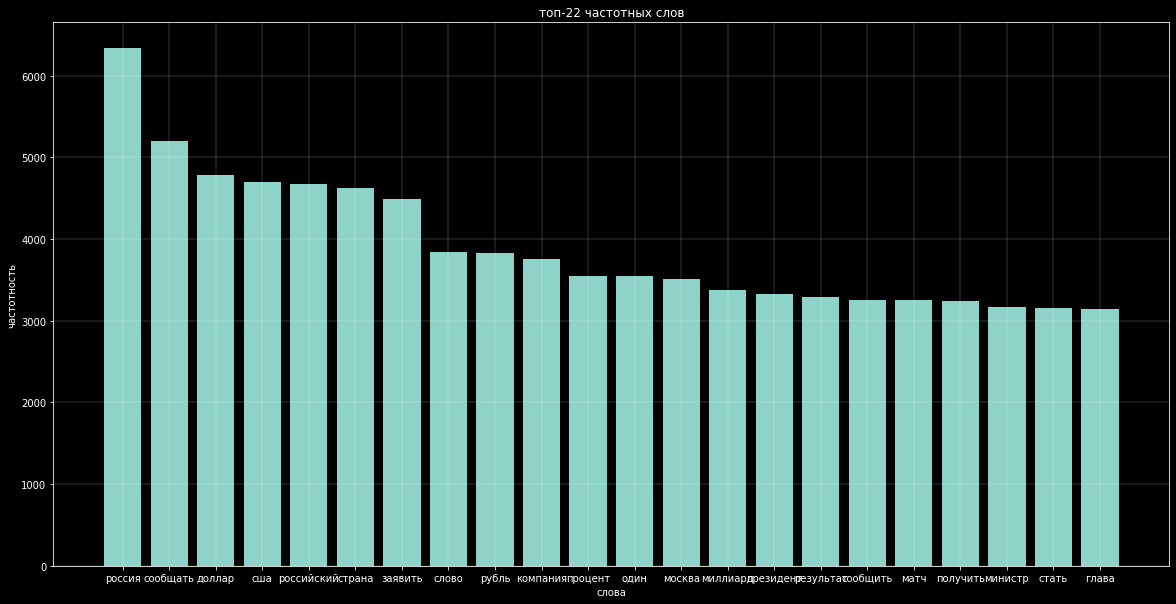

In [33]:
plotFrequencyWords(vocab = vocab,
                   top_words = 22,
                   plt_background = 'dark')

In [34]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(tfidf_vect_train, y_train)

pred_lr = lr.predict(tfidf_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.92644   0.96730   0.94643     10702
         Мир    0.89568   0.90505   0.90034     27245
      Россия    0.91805   0.87307   0.89499     30898
       Спорт    0.97625   0.98376   0.97999     11575
   Экономика    0.90159   0.94104   0.92089     15265

    accuracy                        0.91695     95685
   macro avg    0.92360   0.93404   0.92853     95685
weighted avg    0.91703   0.91695   0.91668     95685

confusion_matrix:
[[10352   135   164    19    32]
 [  361 24658  1630    80   516]
 [  391  2386 26976   143  1002]
 [   24    60    86 11387    18]
 [   46   291   528    35 14365]]
CPU times: user 3min 49s, sys: 7min 52s, total: 11min 41s
Wall time: 1min 37s
